In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
from math import ceil,sin,cos, atan2, pi, sqrt
import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
# Define paths
local = 0 #Set to 0 when working on server
paths = path(local)
config='/home/jvalenti/MOAD/analysis-jose/OParcels/neutral_iona.yaml'

In [3]:
param = load_config1(config)
start = datetime(param['startdate']['year'], param['startdate']['month'], param['startdate']['day']) #Start date
Tmax = param['param']['length'] # Set Time length [days] 
duration = timedelta(days=Tmax)
dt = param['param']['dt'] #toggle between - or + to pick backwards or forwards 
N = param['param']['N'] # number of deploying locations
n = param['param']['n'] # 1000   # number of particles per location
dmin = param['param']['dmin'] #minimum depth
dd = param['param']['dd'] #max depth difference from dmin
name = param['file']['name'] #name output file

daterange = [start+timedelta(days=i) for i in range(Tmax)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)

In [4]:
Dat=xr.open_dataset(paths['coords'],decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]
clon, clat = [float(outf_lon)],[float(outf_lat)]

In [5]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

In [6]:
surf = ds.beached
age = ds.tau
lat = ds.lat
lon = ds.lon
time = ds.time
resurf = []
lonsurf = []
latsurf = []
times = []

for i in range (age.shape[0]):
    if np.argmax(np.array(surf[i,:])==6)==0:
        if np.array(surf[i,:]==6)[0]:
            resurf.append(age[i,np.argmax(np.array(surf[i,:])==6)].values.item())   
            lonsurf.append(lon[i,np.argmax(np.array(surf[i,:])==6)].values.item())  
            latsurf.append(lat[i,np.argmax(np.array(surf[i,:])==6)].values.item()) 
        else:
            resurf.append(np.nan)
            latsurf.append(np.nan)
            lonsurf.append(np.nan)
    else:
        resurf.append(age[i,np.argmax(np.array(surf[i,:])==6)].values.item())   
        lonsurf.append(lon[i,np.argmax(np.array(surf[i,:])==6)].values.item())   
        latsurf.append(lat[i,np.argmax(np.array(surf[i,:])==6)].values.item())   
    #times.append(time[i,np.argmax(np.array(surf[i,:])==6)].values.item())   
    

In [214]:
days = (np.array(resurf)/86400)
daysm = []
dayse = []
for i in range(200):
    daysm.append(np.nanmean(days[i*50:(i+1)*50]))
    dayse.append(np.nanstd(days[i*50:(i+1)*50]))

latm = []
lonm = []
for i in range(200):
    latm.append(np.nanmean(latsurf[i*50:(i+1)*50]))
    lonm.append(np.nanmean(lonsurf[i*50:(i+1)*50]))

dayse = dayse/np.sqrt(50)
daysmin = daysm-dayse
daysmax = daysm+dayse

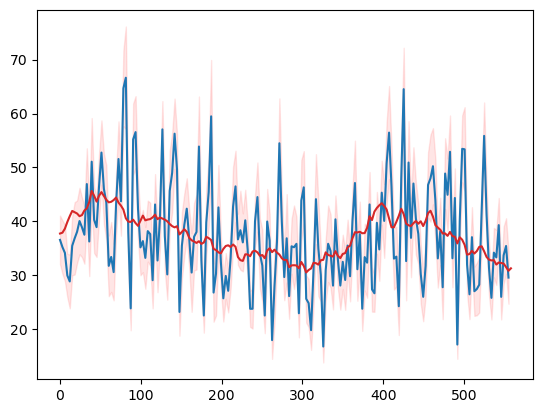

In [231]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
plt.plot(np.linspace(0,3*185,185),daysm[:185])
b = moving_average(daysm, n=15)
plt.plot(np.linspace(0,3*186,186),b,c='tab:red')
plt.fill_between(np.linspace(0,3*185,185),y1=daysmin[:185], y2=daysmax[:185],color='r',alpha=0.1)

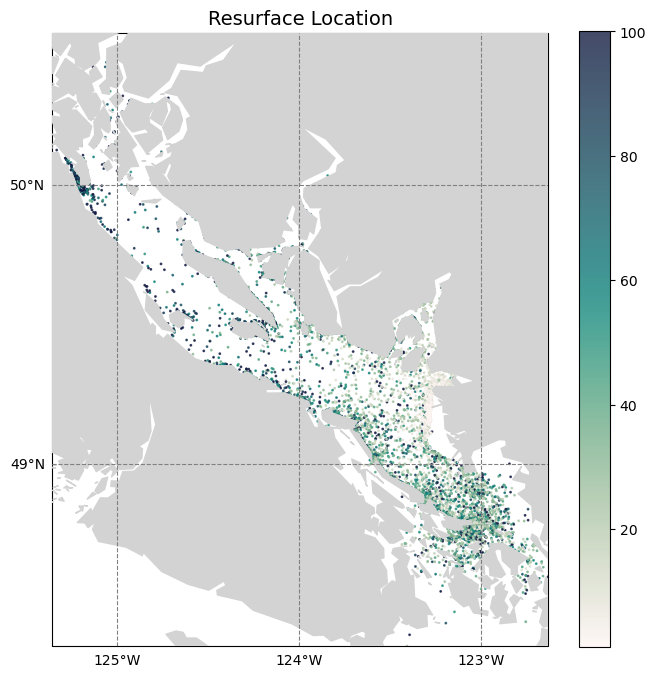

In [184]:
lonmin= np.nanmin(lonsurf)
lonmax= np.nanmax(lonsurf)
latmin= np.nanmin(latsurf)
latmax= np.nanmax(latsurf)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='lightgray',edgecolor='lightgray'),zorder=4)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False
plt.title('Resurface Location',fontsize='14')
sc=plt.scatter(lonsurf,latsurf,transform=crs.PlateCarree(),zorder=2,alpha=0.8,s=1,c=days,cmap=cmocean.cm.tempo,vmin=1,vmax=100)
plt.colorbar(sc)

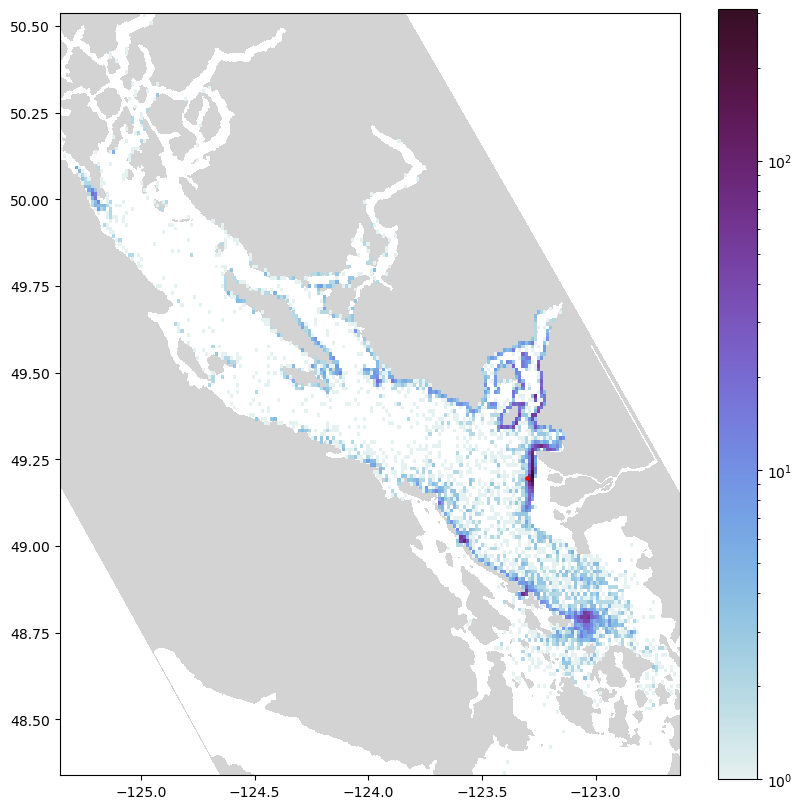

In [180]:
bad_indices = np.isnan(lonsurf)
good_indices = ~bad_indices
lonsurf = np.array(lonsurf)
latsurf = np.array(latsurf)
good_x = lonsurf[good_indices]
good_y = latsurf[good_indices]
fig, axs = plt.subplots(1,1,figsize = (10,10))
plt.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray',zorder=1)
plt.scatter(clon, clat, c='r',s=5,zorder=3)
plt.hist2d(good_x,good_y,200,norm = colors.LogNorm(), cmap =cmocean.cm.dense,zorder=2)
plt.colorbar()
f = 1.0/np.cos(49*np.pi/180)
plt.gca().set_aspect(f)

In [81]:
res = ds.beached[:200*50,:]
a = 0
for i in range(len(res)):
    if 6 in ds.beached[i,:]:
        a+=1
print(f'{(a/len(res))*100}% of the particles resurfaced in the run time.')

99.59% of the particles resurfaced in the run time.


In [154]:
def scatter_particles(ax, N ,n,nmin, nmax,yvar,lon,age,HD=1,colors='b'):
    '''scatter_particles(ax, N ,n,nmin, nmax,yvar,lon,HD=0,colors=colores)
    Use this function to scatter particles with different colours for each deploy location
    N= number of deploying sites,n=number of particles oper location, nmin,max=time min,max, yvar is the variable to plot on the yaxis, 
    Keep HD to 0 unless you want to plot with cartopy (only works for maps so yvar= latitude)
    '''
    
    scatter=[]
    #N is the number of stations, n the number of particles
    #Color is a list of strings picking the desired colors
    #nmin is t0, nmax is tmax
    #yvar is the y coordinate, lon is the longitud array
    #HD (1 for cartopy plot) 0 otherwise
    
    if HD == 0:
        if nmin==nmax:
            scatter.append(ax.scatter(lon[:,nmin], yvar[:,nmin],s=1,c=age[:,nmin],cmap=cmocean.cm.dense))
        else:
            
            scatter.append(ax.scatter(lon[:, nmin:nmax], yvar[:, nmin:nmax],s=1,color=colors))
    else:
        if nmin==nmax:
            scatter.append(ax.scatter(lon[:, nmin], yvar[:, nmin],s=1,transform=crs.PlateCarree(),zorder=1,c=age[:,nmin],cmap=cmocean.cm.dense,vmin=0,vmax=450))
        else:
            scatter.append(ax.scatter(lon[:, nmin:nmax], yvar[:, nmin:nmax],s=1,transform=crs.PlateCarree(),zorder=1,color=colors))
        
    return scatter

In [155]:
def mapanimation(outfile,N,n,clon,clat,fps=1,local=1):
    '''mapanimation(outfile,N,n,clon,clat,fps=1,local=1)
    Use this function to return an animated map of the particles,
    keep local=1 when working local and = 0 when remote. 
    outfile is the name of the output file from OP
    N= number of deploying sites,n=number of particles oper location,
    clat,clon location of deploying locations.
    '''
    coords,mask,ds = output(outfile,local)
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
    ax.add_feature(feature.GSHHSFeature('high', facecolor='lightgray',edgecolor='lightgray'),zorder=2)
    gl = ax.gridlines(
        linestyle='--', color='gray', draw_labels=True,
        xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=2)
    gl.top_labels, gl.right_labels = False, False
    plt.title('Resurface Location',fontsize='14')
    ss = plt.scatter(clon,clat,color='r',zorder=3)
    
    ax.grid()
    f = 1.0/np.cos(49*np.pi/180)
    plt.gca().set_aspect(f)
    #t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
    #t.set_text('')
    ss = []#scatter_particles(ax, N,n, 0,0, ds.lat,ds.lon)

    def update(frame):
        #tstamp = ds.time[0, frame].values.astype('datetime64[s]').astype(datetime)
        #t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
        global ss
        for scat in ss:
            scat.remove()
        ss = scatter_particles(ax, N,n, frame,frame, ds.lat,ds.lon,ds.z)
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(ds.lon[0,:]),fps))


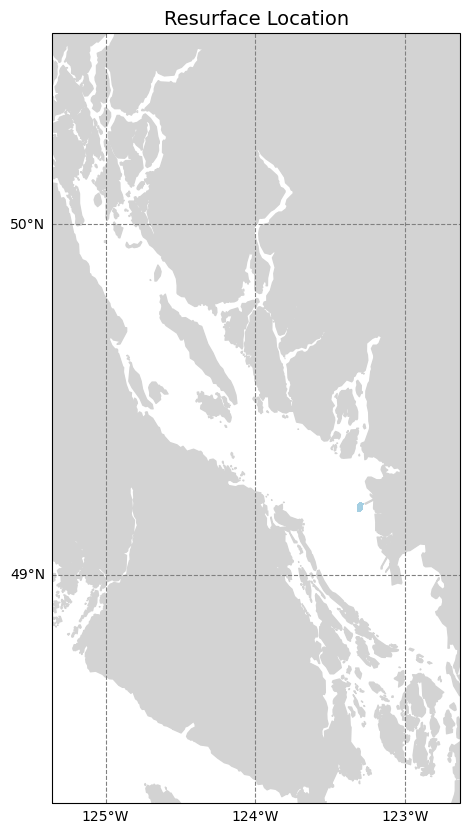

In [160]:
fps=1
anim = mapanimation(outfile,N,n,clon,clat,fps,local)
f = r"/home/jvalenti/MOAD/animations/resurf.gif" 
FFwriter = animation.FFMpegWriter()
anim.save(f, writer = FFwriter)

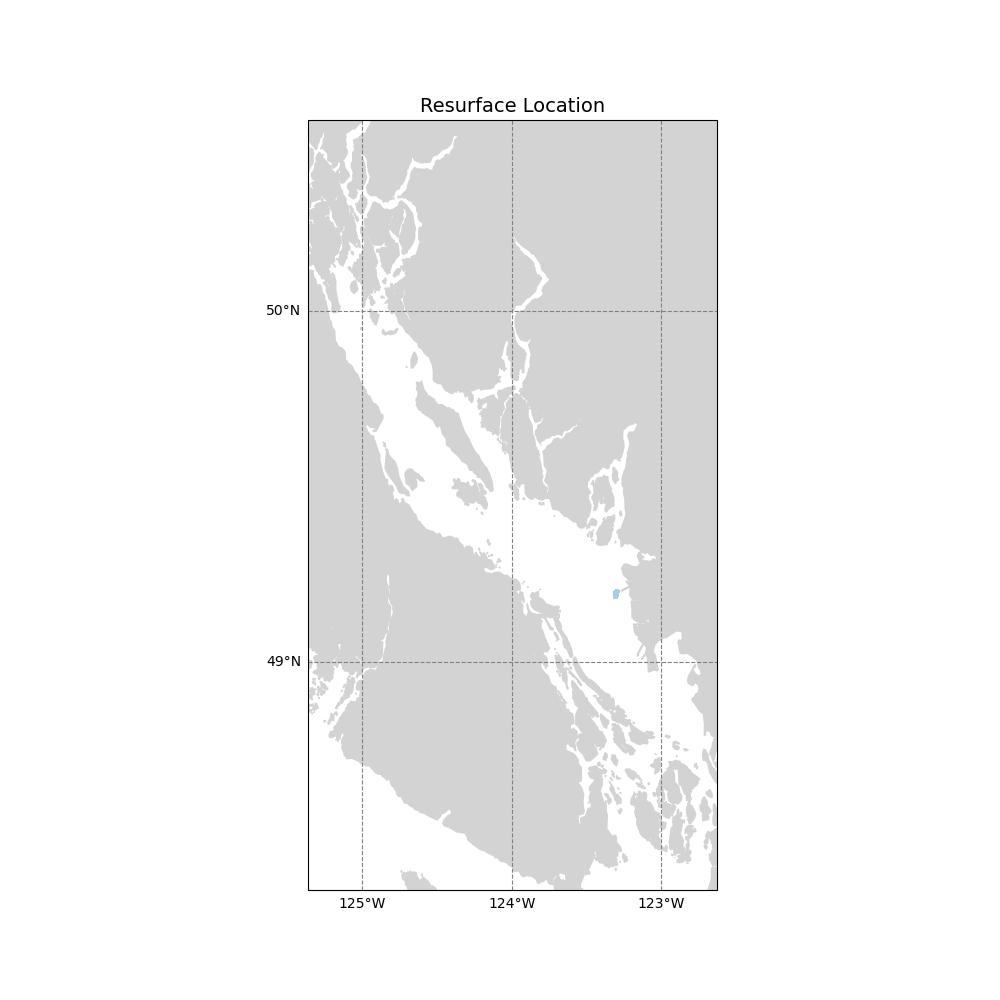

In [161]:
with open(f,'rb') as anim:
     display(Image(anim.read()))